In [42]:
%matplotlib notebook
import numpy as n
pi = n.pi
arccos = n.arccos
acos = arccos
import matplotlib.pyplot as p
p.style.use('mysty')
import figfun as f
import scipy.optimize as so
from scipy.interpolate import interp1d
from pandas import read_excel
sports = 1

# Mohr's Hosford - Coulomb Failure model

##### First off, I need the True Stresses at failure

In [43]:
# Specify the constit you wanna use
constit, mean_or_max = 'VM', 'max'

# First load up the failure data 
d = read_excel('../Figs/Kaleidagraph/TTGM_SetData.xlsx', sheet_name='Table 2', index_col='Expt')
d.drop(range(11,16), inplace=True)
d1 = read_excel('../Figs/Kaleidagraph/TTGM_SetData.xlsx', sheet_name='Table 1', index_col='Expt')
d1.drop(range(11,16), inplace=True)
d['t_o'] = d1.t
# Convert ksi\n(MPa) strings of stress into usable floats
try:
    d.SigF = [float(d.SigF.values[j].split('\r')[0]) for j in range(len(d))]
    d.TauF = [float(d.TauF.values[j].split('\r')[0]) for j in range(len(d))]
    d.t_o = [float(d.t_o.values[j].split('\r')[0]) for j in range(len(d))]
except ValueError:
    d.SigF = [float(d.SigF.values[j].split('\n')[0]) for j in range(len(d))]
    d.TauF = [float(d.TauF.values[j].split('\n')[0]) for j in range(len(d))]
    d.t_o = [float(d.t_o.values[j].split('\n')[0]) for j in range(len(d))]
    
x = read_excel('../Figs/Kaleidagraph/TTGM_SetData.xlsx', sheet_name='FailureStrain', index_col='Expt')
x.drop(range(12,16), inplace=True)
Σ = x['{}-Triax'.format(constit)].values
efmn = x['{}-Mean'.format(constit)].values
efmx = x['{}-Max'.format(constit)].values

# Make sure my various dataframes are aligned
assert n.all(x.index == d.index) and n.all(d.index == d1.index)

# Now get beta for each of these expts
d['beta'] = n.ones(len(d))
alpha_beta = n.genfromtxt('./PlaneStn_YldFun.dat', delimiter=',')
beta = interp1d(alpha_beta[:,0], alpha_beta[:,1:], axis=0).__call__(d['alp'])
# Correct for pure tension
beta[n.any(n.isnan(beta), axis=1)] = alpha_beta[-1,1:]
colmap = {'VM':0, 'H8':1, 'Anis':2}
d['beta'] = beta[:,colmap[constit]]

if mean_or_max != 'max':
    efm = efmn.copy()
    mean_or_max = 'mean'
else:
    efm = efmx.copy()

# Load up the constitutive model
mat = read_excel('FailureCriteriaFit_StsStnCurves.xlsx', sheet_name=constit, header=None).values

/home/sherman/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/sherman/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


In [44]:
# Defining functions for the HC model

def stress_measures(sig, tau, beta):
    hoop = beta*sig
    I1 = hoop+sig
    J2 = tau**2 + (-hoop/3 - sig/3)**2/2 + (-hoop/3 + 2*sig/3)**2/2 + (2*hoop/3 - sig/3)**2/2
    J3 = 2*hoop**3/27 - hoop**2*sig/9 - hoop*sig**2/9 + hoop*tau**2/3 + 2*sig**3/27 + sig*tau**2/3
    triax = (I1/3)/sqrt(3*J2)
    qbar = 1 - (2/pi)*arccos( sqrt(27/4)*J3/(J2**1.5) )
    return triax, qbar
def f1(q):
    return (2/3)*n.cos(pi*(1-q)/6)
def f2(q):
    return (2/3)*n.cos(pi*(3+q)/6)
def f3(q):
    return -(2/3)*n.cos(pi*(1+q)/6)
def F(θ,a):
    return ( (1/2)*( n.abs(f1(θ) - f2(θ))**a + n.abs(f2(θ) - f3(θ))**a + n.abs(f3(θ) - f1(θ))**a ))**(1/a)

def HC(params, sig, tau, beta, constit='VM'):
    hoop = beta*sig
    σc, a, c = params
    η, θ = stress_measures(sig,tau, beta)
    rtn = σc / (F(θ,a) + c*(f1(θ) + f3(θ) + 2*η))
    if constit == 'H8':
        return rtn * F(θ,8.0)
    else:
        return rtn

def plot_HC(params, α, β, constit='VM'):
    σc, a, c = params
    η = α*(β + 1)/(3*sqrt(α**2*β**2 - α**2*β + α**2 + 3))
    θ = (-2*acos(3*sqrt(6)*α*(β + 1)*(α**2*(β - 2)*(2*β - 1) + 9)/
                 (α**2*(β - 2)**2 + α**2*(β + 1)**2 + α**2*(2*β - 1)**2 + 18)**(3/2)) + pi)/pi
    rtn = σc / (F(θ,a) + c*(f1(θ) + f3(θ) + 2*η))
    if constit == 'H8':
        return rtn * F(θ,8.0)
    else:
        return rtn    
    
def err(params, sig, tau, beta, sigeq_fail, constit='VM'):
        return HC(params, sig, tau, beta, constit) - sigeq_fail
    
bounds = ((0, 0, 0),(n.inf, 2, n.inf))

In [45]:
# Calculate the tru thickness at failure in each expt
d['t'] = n.ones(len(d))
for k in d.index:
    # [0-5]Mean VM-H8-Anis-de00-01-00, [6-11]Max VM-H8-Anis-de00-01-00, [12-13]Mean, max Classic LEp
    e = n.genfromtxt('../../TTGM-{}_FS19SS6/IncrementalAnalysis/NewFilterResults_3med.dat'.format(k), delimiter=',')[-1]
    e = n.array([[e[3], e[4]],[e[4],e[5]]])
    e1, e2 = n.linalg.eigvalsh(e)
    d.loc[k].t = d.loc[k].t_o * n.exp(-(e1+e2))

# Now calc. the tru sts at failure
d.SigF *= d.t_o / d.t
d.TauF *= d.t_o / d.t

# And the VM Eq.sts
d['VM'] = n.sqrt( ( (d.SigF/2 - d.SigF)**2 + (d.SigF)**2 + (-d.SigF/2)**2 + 6*d.TauF**2)/2 )
sig, tau, se = [d[j].values for j in ('SigF', 'TauF','VM')]

# A nice way to check that I am calculating d.VM and my f1, f2 f3 functions correctly!
σ1 = d.VM * (f1(d['Q-bar']) + d.Triax)
σ2 = d.VM * (f2(d['Q-bar']) + d.Triax)
σ3 = d.VM * (f3(d['Q-bar']) + d.Triax)
assert n.allclose( (((1/2)*((σ1-σ2)**2 + (σ2-σ3)**2 +(σ3-σ1)**2))**.5).values, d.VM.values)

# And finally the H8 Eq sts
d['H8'] = (((1/2)*((σ1-σ2)**8 + (σ2-σ3)**8 +(σ3-σ1)**8))**.125)

##### This works ok:  I get the equivalent stress by taking the measured failure strain and interpolating into Kelin's stress-strain curves

In [46]:
# Optimizing to the stress I get if I interpolate from the sts-stn curve using the failure strain!
# Optimizing to the true stress I calculated at failure

sts = interp1d(mat[:,0], mat[:,1], fill_value='extrapolate').__call__(efm)

res = so.least_squares(err, x0=[1,1,1], args=(d.SigF.values, d.TauF.values, d.beta.values, sts, constit), bounds=bounds)

print(res.x)

[59.3014 1.54939 0.133064]


<IPython.core.display.Javascript object>


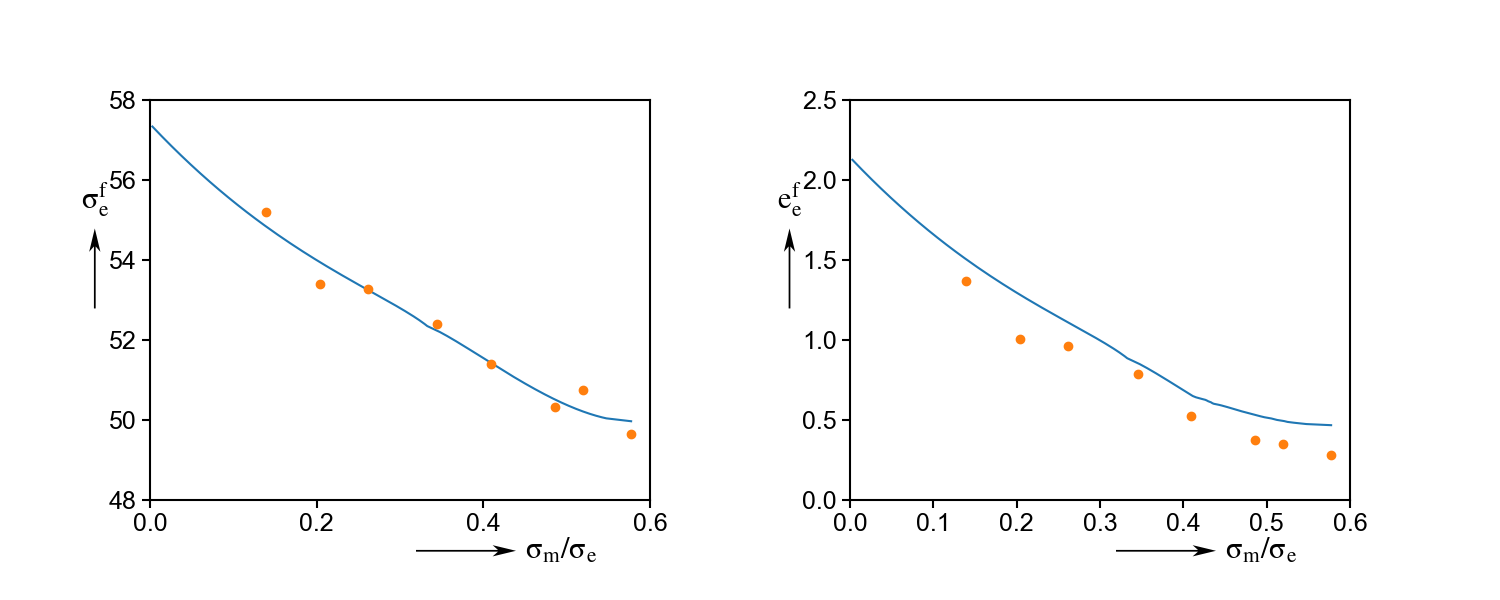

In [47]:
fig, ax1, ax2 = f.make12()

# = n.empty(1000)
#α[:-50] = n.linspace(0.0,8,950)
#α[-50:] = n.linspace(8,20,50)
#β = interp1d(alpha_beta[:,0], alpha_beta[:,1:], axis=0).__call__(\alph)
# Correct for pure tension
#β[n.any(n.isnan(beta), axis=1)] = alpha_beta[-1,1:]
#β = β[:,colmap[constit]]
α = alpha_beta[:,0]
#if constit == 'VM':  α[-1] = 20
β = alpha_beta[:,1+colmap[constit]]
η = α*(β + 1)/(3*sqrt(α**2*β**2 - α**2*β + α**2 + 3))

ax1.plot(η, plot_HC(res.x, α, β, constit), label=('{}\n$\\sigma_c$,a,c\n' + '{:.3f}\n'*3).format(constit,*res.x))
ax1.plot(d.Triax, sts, 'o')
ax1.set_xlabel('$\\sigma_m/\\sigma_e$')
ax1.set_ylabel('$\\sigma_e^f$')
#f.ezlegend(ax1)

eef_pred = interp1d(mat[:,1], mat[:,0], fill_value='extrapolate').__call__(plot_HC(res.x, α, β, constit))
ax2.plot(η, eef_pred)
ax2.axis(xmin=0,ymin=0,xmax=0.6)
ax2.set_xlabel('$\\sigma_m/\\sigma_e$')
ax2.set_ylabel('$e_e^f$')
ax2.plot(d.Triax, d.efmn, 'o')

[f.myax(x) for x in (ax1,ax2)]

##### This doesn't work so well for HC:  Getting the true eq. sts at failure using incompressibility and the tru wall thickness

# Optimizing to the true stress I calculated at failure

if constit == 'H8':
    res = so.least_squares(err, x0=[1,1,1], args=(d.SigF.values, d.TauF.values, d.H8.values, constit), bounds=bounds)
else:
    res = so.least_squares(err, x0=[1,1,1], args=(d.SigF.values, d.TauF.values, d.VM.values, constit), bounds=bounds)

print(res.x)

fig, ax1, ax2 = f.make12(scale=.8)

ax1.plot(d.Triax, HC(res.x, sig, tau), label=('{:.3f}\n'*3).format(*res.x))
ax1.plot(d.Triax, d.VM.values, '.')
ax2.set_title('Mapped to Failure strain')
f.ezlegend(ax1)

eef_pred = interp1d(mat[:,1], mat[:,0], fill_value='extrapolate').__call__(HC(res.x, sig, tau))
ax2.plot(d.Triax, eef_pred)
ax2.plot(d.Triax, d.efmn, '.')

p.figure()
for name in ['VM', 'H8']:
    d = read_excel('FailureCriteriaFit_StsStnCurves.xlsx', sheetname=name, index_col=None, header=None)
    p.plot(d[0], d[1], label=name)
f.ezlegend(p.gca())

# Fitting Johnson Cook and Hosford-Coulomb to our failure data
#### Demonstration that curve_fit and least_squares do the same

In [48]:
# First load up the failure data 
d = read_excel('../Figs/Kaleidagraph/TTGM_SetData.xlsx', sheet_name='FailureStrain')
d = d[~n.in1d(d.Expt, n.arange(11,16))]
Σ, efmn, efmx = d['{}-Triax'.format(constit)].values, d['{}-Mean'.format(constit)].values, d['{}-Max'.format(constit)].values
if mean_or_max != 'max':
    efm = efmn.copy()
    mean_or_max = 'mean'
else:
    efm = efmx.copy()

##### Johnson-Cook fit via curve_fit

<IPython.core.display.Javascript object>


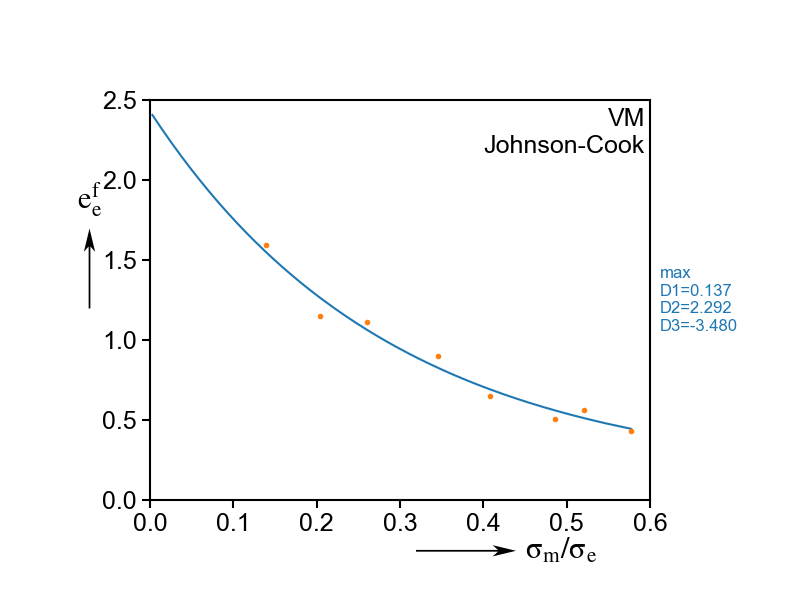

In [49]:
p.figure()
def JC(triax, D1, D2, D3):
    return D1 + D2*n.exp(D3*triax)

bounds = ((0,-n.inf, -n.inf), (n.inf, n.inf, 0))

for efm, lab in zip([efm], [mean_or_max]):
    params, info = so.curve_fit(JC, Σ, efm, bounds=bounds)
    x = n.linspace(0, 2/3)
    p.plot(η, JC(η,*params), label='{}\nD1={:.3f}\nD2={:.3f}\nD3={:.3f}'.format(lab, *params))
    p.plot(Σ, efm, '.')

f.ezlegend(p.gca())
f.eztext(p.gca(), '{}\nJohnson-Cook'.format(constit), 'ur')
p.xlabel('$\\sigma_m/\\sigma_e$')
p.ylabel('$e_e^f$')
p.axis(xmax=0.6)
f.myax(p.gca())

In [50]:
if 1:
    p.savefig('Failure_JC_{}_{}'.format(constit, mean_or_max), dpi=125)
    fig.savefig('Failure_HC_{}_{}'.format(constit,mean_or_max), dpi=125)
    n.savetxt('Failure_JCHC_{}_{}.dat'.format(constit, mean_or_max), X=n.c_[η, JC(η,*params), eef_pred ], fmt='%.6f', delimiter=',', header='[0]Triax, [1]JC, [2]MohrHC')

##### Johnson-Cook fit via least_squares

def JC2(D, triax):
    D1, D2, D3 = D
    return D1 + D2*n.exp(D3*triax)

def err(D, triax, ef):
    return (JC2(D,triax) - ef)

def jac(D, triax, worthless):
    D1, D2, D3 = D
    J = n.empty((triax.size, 3))
    J[:,0] = 1
    J[:,1] = n.exp(D3*triax)
    J[:,2] = triax*D2*n.exp(D3*triax)
    return J

p.figure()
for efm, lab in zip([efmx, efmn], ['Max','Mean']):
    res = so.least_squares(err, x0=[1,1,-1], args=(Σ,efm), jac=jac, bounds=bounds)
    x = n.linspace(0, 2/3)
    p.plot(x, JC2(res.x, x), label='{}\n{:.3f}\n{:.3f}\n{:.3f}'.format(lab, *res.x))
    p.plot(Σ, efm, '.')
f.ezlegend(p.gca())

<IPython.core.display.Javascript object>


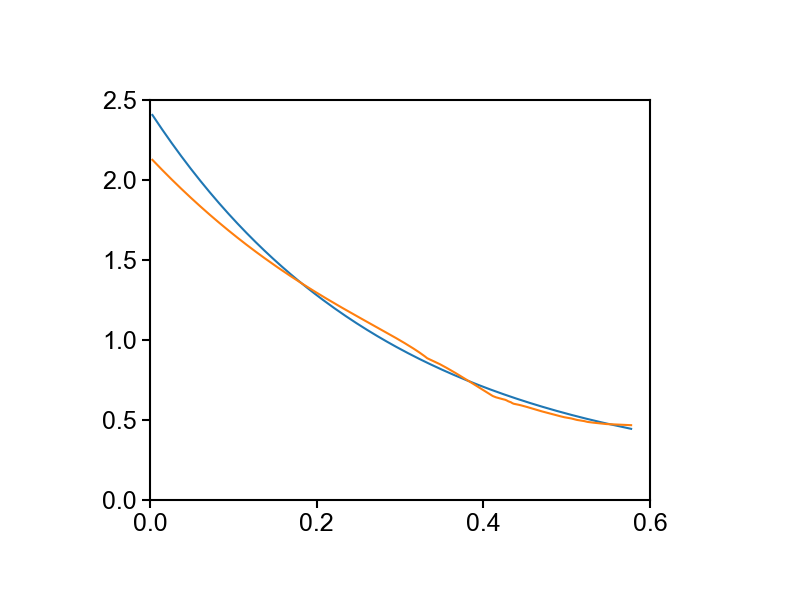

In [51]:
z = n.genfromtxt('Failure_JCHC_{}_{}.dat'.format(constit,mean_or_max), delimiter=',')
p.figure()
p.plot(z[:,0], z[:,1:])